In [17]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
import numpy as np

# Load the EMNIST dataset
# Here we're using the "byclass" split, but you can replace "byclass" with another split if needed
builder = tfds.builder('emnist/byclass')
builder.download_and_prepare()
datasets = builder.as_dataset(as_supervised=True)  # as_supervised=True will return tuple (img, label)
train_dataset, test_dataset = datasets['train'], datasets['test']

# Preprocessing function to normalize and reshape images
def preprocess(img, label):
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, -1)  # Add a channel dimension
    return img, label

# Apply the preprocessing function to the dataset
train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# You may want to batch and prefetch the dataset for performance
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Modify the architecture slightly
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),  # Added layer
    layers.BatchNormalization(),
    layers.Dropout(0.25),  # Added layer

    layers.Flatten(),
    layers.Dense(256, activation='relu'),  # Increased capacity
    layers.Dropout(0.5),
    layers.Dense(62, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_6 (Bat  (None, 26, 26, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 10, 10, 64)       

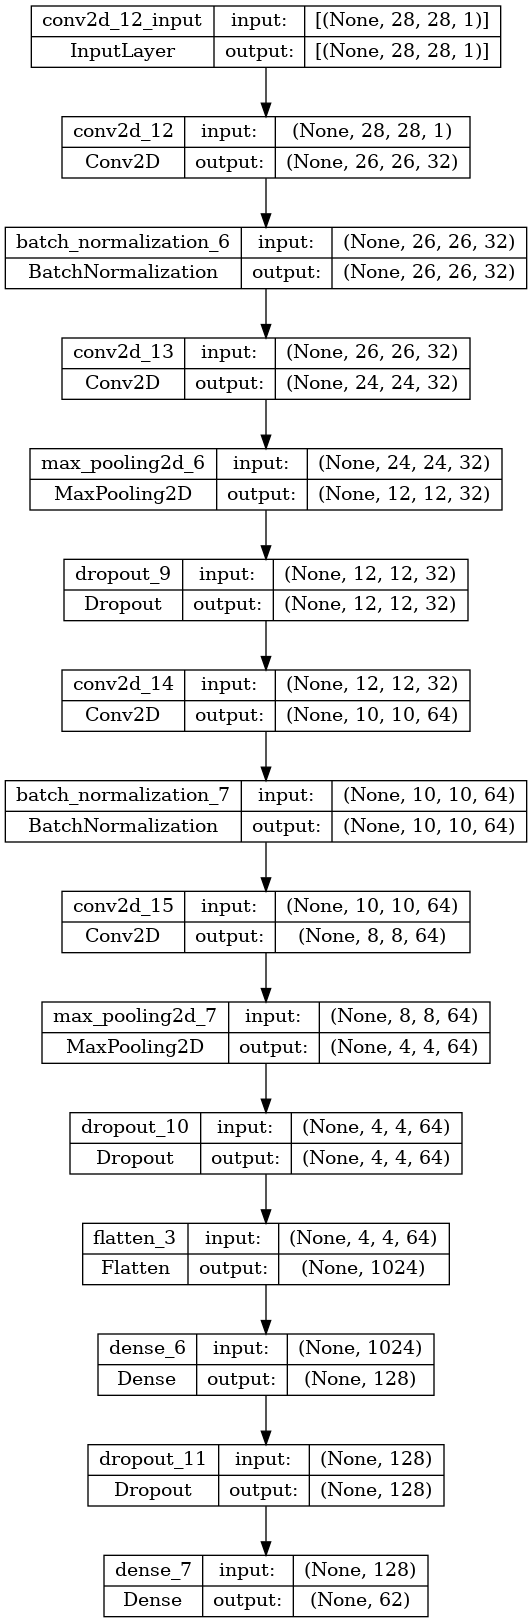

In [18]:
from tensorflow.keras.utils import plot_model

# Generate a plot of the model architecture-
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [19]:
# Ouput the number of images in the training set
print("Number of training images: ", builder.info.splits['train'].num_examples)
print("Number of test images: ", builder.info.splits['test'].num_examples)

Number of training images:  697932
Number of test images:  116323


In [21]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10


21811/21811 [==============================] - 215s 10ms/step - loss: 0.7251 - accuracy: 0.7731 - val_loss: 0.4187 - val_accuracy: 0.8494
Epoch 2/10
21811/21811 [==============================] - 221s 10ms/step - loss: 0.5092 - accuracy: 0.8285 - val_loss: 0.3921 - val_accuracy: 0.8563
Epoch 3/10
21811/21811 [==============================] - 221s 10ms/step - loss: 0.4811 - accuracy: 0.8365 - val_loss: 0.3891 - val_accuracy: 0.8563
Epoch 4/10
21811/21811 [==============================] - 221s 10ms/step - loss: 0.4721 - accuracy: 0.8391 - val_loss: 0.3861 - val_accuracy: 0.8577
Epoch 5/10
21811/21811 [==============================] - 221s 10ms/step - loss: 0.4689 - accuracy: 0.8397 - val_loss: 0.3981 - val_accuracy: 0.8532
Epoch 6/10
21811/21811 [==============================] - 221s 10ms/step - loss: 0.4654 - accuracy: 0.8411 - val_loss: 0.3910 - val_accuracy: 0.8545
Epoch 7/10
 8473/21811 [==========>...................] - ETA: 2:07 - loss: 0.4685 - accuracy: 0.8405

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')

In [ ]:
model.save('models/mnist_cnn_savedmodel')

!tensorflowjs_converter --input_format=tf_saved_model --output_node_names='softmax_tensor' models/mnist_cnn_savedmodel web/models/mnist_cnn_tfjs

In [ ]:
# import tensorflow as tf
# import numpy as np

# # Load the image file
# image_path = '4.png'
# image_string = tf.io.read_file(image_path)

# # Decode the image, convert it to grayscale, and resize it
# img = tf.image.decode_image(image_string, channels=1)
# img = tf.image.resize(img, [28, 28])

# # Normalize the pixel values
# img_array = img / 255.0

# # Expand dimensions to fit the model input shape (1, 28, 28, 1)
# img_array = np.expand_dims(img_array, axis=0)

# # Make a prediction
# predictions = model.predict(img_array)

# # Get the predicted label
# predicted_label = np.argmax(predictions)

# print(f'Predicted label: {predicted_label}')